In [1]:
import pandas as pd
import numpy as np
import time
import xgboost as xgb
from xgboost import XGBClassifier,plot_importance
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import gc
import warnings
%matplotlib inline
from matplotlib.pylab import rcParams
import os
import warnings 
warnings.simplefilter('ignore')
rcParams['figure.figsize'] = 12, 4
warnings.simplefilter("ignore")
OriginDataDir = '../../Data/OriginData'
TrainTestDataDir = '../../Data/TrainTestData'
ModelSaveDir = 'models'
ResultSaveDir = 'result'

/usr/share/anaconda2/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/share/anaconda2/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/share/anaconda2/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/share/anaconda2/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/share/anaconda2/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/share

In [2]:
def loadData(DataName):
    DataPath = os.path.join(TrainTestDataDir, DataName)
    if not os.path.exists(DataPath):
        print('%s does not exist!' % DataPath)
        return
    OriginData = pd.read_csv(DataPath, index_col=0)
    #OriginData = OriginData.sample(frac=1)  # 打乱顺序后返回
    return OriginData


def NormalData(TrainData, TestData):
    # 对一些列的均值大于100的进行归一化处理
    AllData = TrainData.append(TestData)
    for col in AllData.columns:
        if abs(AllData[col].mean())>1:
            scaler = StandardScaler().fit(np.atleast_2d(AllData[col]).T)
            TrainData[col] = scaler.transform(np.atleast_2d(TrainData[col]).T)
    return TrainData

In [3]:
TestData = loadData('AllTest_withnull.csv')
TestID = TestData.SK_ID_CURR.values
TestData.drop('SK_ID_CURR', axis=1, inplace=True)
AllTrainData = loadData('AllTrain_withnull.csv')
AllTrainData.reset_index(drop=True, inplace=True)
AllTrainData.drop('SK_ID_CURR', axis=1, inplace=True)

In [4]:
tmp = AllTrainData.isnull().sum().sort_values(ascending=False)/len(AllTrainData)

In [5]:
tmp.head()

AMT_PAYMENT_CURRENT_std_max         0.802872
AMT_PAYMENT_CURRENT_std_mean        0.802872
AMT_PAYMENT_minus_Total_std_max     0.802872
AMT_PAYMENT_minus_Total_std_mean    0.802872
AMT_PAYMENT_minus_Total_std_min     0.802872
dtype: float64

In [6]:
featureNO = list(tmp[tmp>0.8].index)
print(len(featureNO))

59


In [7]:
features = [x for x in AllTrainData.columns if x != 'TARGET' and x != 'SK_ID_CURR']

In [8]:
len(features)

1339

In [9]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBOOST Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('XGBOOST_ImportantFeats.png')

In [10]:
df_train = AllTrainData
df_test = TestData
num_folds = 5
stratified = False
debug= False

In [11]:
#试试另外一个xgb模型
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=90210)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=90210)
# Create arrays and dataframes to store results
oof_preds = np.zeros(df_train.shape[0])
sub_preds = np.zeros([df_test.shape[0]])
roc_score_list = []
bestModel = None
bestRoc = None
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    clf = XGBClassifier(scale_pos_weight=1,
                    reg_alpha=0.001,
                    reg_lambda=0.001,
                    min_child_weight=4,
                    colsample_bylevel=1,
                    colsample_bytree=0.5,
                    subsample=0.5,
                    max_bin=255,
                    max_depth=16,
                    max_leaves = 40,
                    ter='gbtree',gpu_id = 0,
                    tree_method = 'gpu_hist',
                    objective= 'binary:logistic',
                    n_estimators=10000,
                    nthread=-1,
                    learning_rate =0.001
                   )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= 200, early_stopping_rounds= 100)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x,ntree_limit=clf.best_ntree_limit)[:, 1]
    sub_preds += clf.predict_proba(df_test[features],ntree_limit=clf.best_ntree_limit)[:, 1] / folds.n_splits # - Uncomment for K-fold 
    roc_curr = roc_auc_score(valid_y, oof_preds[valid_idx])
    roc_score_list.append(roc_curr)
    if bestRoc is None or roc_curr>bestRoc:
        bestRoc = roc_curr
        bestModel = clf
    print('best interation:',clf.best_ntree_limit)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr ))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 1340), test shape: (48744, 1339)
Num of Feature: 1339
[0]	validation_0-auc:0.724227	validation_1-auc:0.718033
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[200]	validation_0-auc:0.755017	validation_1-auc:0.744325
[400]	validation_0-auc:0.756929	validation_1-auc:0.745709
[600]	validation_0-auc:0.758716	validation_1-auc:0.746935
[800]	validation_0-auc:0.760038	validation_1-auc:0.747741
[1000]	validation_0-auc:0.761478	validation_1-auc:0.748663


KeyboardInterrupt: 

In [77]:
df_train = AllTrainData
df_test = TestData
num_folds = 5
stratified = False
debug= False

In [11]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds = np.zeros(df_train.shape[0])
sub_preds = np.zeros([df_test.shape[0]])
roc_score_list = []
bestModel = None
bestRoc = None
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    clf = XGBClassifier(learning_rate =0.01, 
                        n_estimators=10000, max_depth = 5 , 
                        min_child_weight = 5, subsample=0.8,
                        colsample_bytree=0.8, objective= 'binary:logistic', 
                       nthread=-1, scale_pos_weight = 1, seed=27, 
                        reg_lambda = 1.2, gpu_id = 0,tree_method = 'gpu_hist')

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x,ntree_limit=clf.best_ntree_limit)[:, 1]
    sub_preds += clf.predict_proba(df_test[features],ntree_limit=clf.best_ntree_limit)[:, 1] / folds.n_splits # - Uncomment for K-fold 
    roc_curr = roc_auc_score(valid_y, oof_preds[valid_idx])
    roc_score_list.append(roc_curr)
    if bestRoc is None or roc_curr>bestRoc:
        bestRoc = roc_curr
        bestModel = clf
    print('best interation:',clf.best_ntree_limit)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr ))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 1260), test shape: (48744, 1259)
Num of Feature: 1259
[0]	validation_0-auc:0.727259	validation_1-auc:0.721573
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:0.763267	validation_1-auc:0.751072
[400]	validation_0-auc:0.784583	validation_1-auc:0.766212
[600]	validation_0-auc:0.802013	validation_1-auc:0.776726
[800]	validation_0-auc:0.813611	validation_1-auc:0.782052
[1000]	validation_0-auc:0.822889	validation_1-auc:0.785285
[1200]	validation_0-auc:0.830936	validation_1-auc:0.787434
[1400]	validation_0-auc:0.838182	validation_1-auc:0.788997
[1600]	validation_0-auc:0.844734	validation_1-auc:0.790011
[1800]	validation_0-auc:0.850599	validation_1-auc:0.790844
[2000]	validation_0-auc:0.856127	validation_1-auc:0.791489
[2200]	validation_0-auc:0.860886	validation_1-auc:0.79187
[2400]	validation_0-auc:0.86573	validation_1-auc

best interation: 4443
Fold  5 AUC : 0.792779


In [12]:
bestModel

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, gpu_id=0, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=10000, n_jobs=1, nthread=-1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.2, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8, tree_method='gpu_hist')

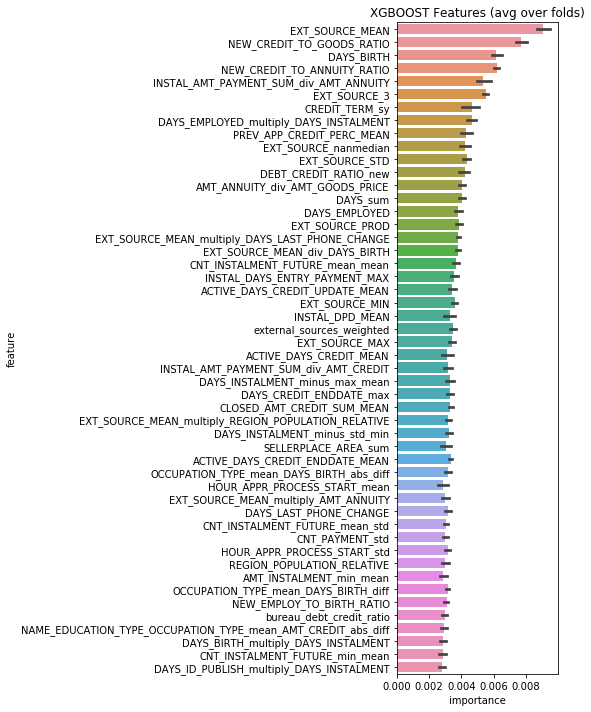

In [13]:
display_importances(feature_importance_df)

In [14]:
# Write submission file and plot feature importance
gender_submission = pd.DataFrame({'SK_ID_CURR':TestID,'TARGET':sub_preds})
gender_submission.to_csv(os.path.join(ResultSaveDir,'result_xgb_test15.csv'), index = False)

In [21]:
gender_submission.head()

,SK_ID_CURR,TARGET
0,100001,0.039121
1,100005,0.187962
2,100013,0.034294
3,100028,0.037446
4,100038,0.150876


In [12]:
feats = feature_importance_df[["feature", "importance"]].groupby("feature").mean()\
.sort_values(by="importance", ascending=False)

In [13]:
featscum = feats.cumsum()
featscum.head()

,importance
feature,
NEW_CREDIT_TO_GOODS_RATIO,0.007762
EXT_SOURCE_MEAN,0.014698
NEW_CREDIT_TO_ANNUITY_RATIO,0.021354
DAYS_BIRTH,0.027828
DEBT_CREDIT_RATIO_new,0.033773


In [16]:
feat_keep = featscum[featscum.importance<0.99].index.tolist()

In [17]:
len(feat_keep)

780

In [18]:
features = feat_keep

## 获取前50个比较重要的特征

In [56]:
features30 = list(feature_importance_df[["feature", "importance"]].groupby("feature").mean()\
.sort_values(by="importance", ascending=False)[:30].index)

In [57]:
features30

['EXT_SOURCE_MEAN',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'DAYS_BIRTH',
 'EXT_SOURCE_3',
 'CREDIT_TERM_sy',
 'EXT_SOURCE_nanmedian',
 'DEBT_CREDIT_RATIO_new',
 'DAYS_CREDIT_ENDDATE_max',
 'DAYS_EMPLOYED',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'EXT_SOURCE_gap',
 'PREV_APP_CREDIT_PERC_MEAN',
 'REGION_POPULATION_RELATIVE',
 'DAYS_INSTALMENT_minus_max_mean',
 'EXT_SOURCE_STD',
 'AMT_PAYMENT_minus_mean_mean',
 'EXT_SOURCE_PROD',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'EXT_SOURCE_MEAN_multiply_AMT_ANNUITY',
 'INSTAL_AMT_PAYMENT_SUM',
 'CNT_INSTALMENT_FUTURE_mean_mean',
 'DAYS_ENDDATE_FACT_max',
 'EXT_SOURCE_MAX',
 'external_sources_weighted',
 'INSTAL_DPD_MEAN',
 'EXT_SOURCE_MEAN_div_DAYS_BIRTH',
 'CNT_INSTALMENT_FUTURE_min_mean',
 'DAYS_ID_PUBLISH_multiply_DAYS_INSTALMENT',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN']

In [58]:
#通过xgboost选出来的特征剔除异常点
AllTrainDataNULLcount = AllTrainData[features30].isnull().sum(axis=1).sort_values(ascending=False)/len(features30)

In [61]:
AllTrainDataNULLcount[AllTrainDataNULLcount>0.3].index

Int64Index([ 20988, 129183,  14869,  96792,  10910, 177091, 298610, 307387,
            262758, 218469,
            ...
            197165, 196801, 200154,    650, 302881, 188515, 199902, 128367,
            191210,  37912],
           dtype='int64', length=12759)

In [65]:
AllTrainData.shape

(294752, 1244)

In [64]:
AllTrainData.drop(AllTrainDataNULLcount[AllTrainDataNULLcount>0.3].index,inplace=True)

## 来看看数据的异常点

In [24]:
#看列的缺失情况
ColNullTrain = AllTrainData.isnull().sum().sort_values(ascending=False)/len(AllTrainData)
ColNullTest = TestData.isnull().sum().sort_values(ascending=False)/len(TestData)

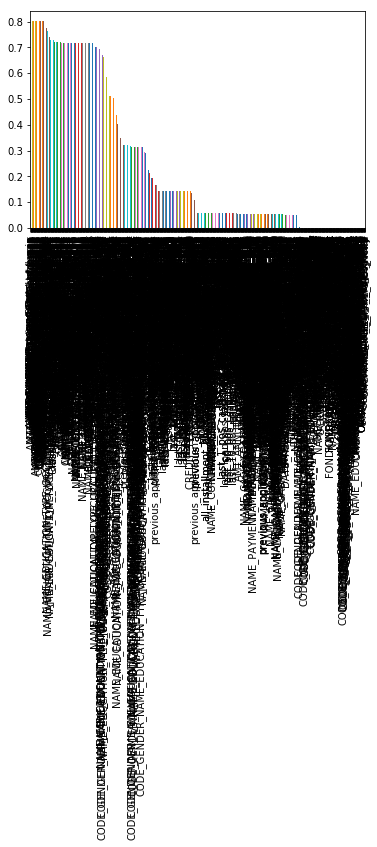

In [25]:
ColNullTrain.plot(kind='bar')

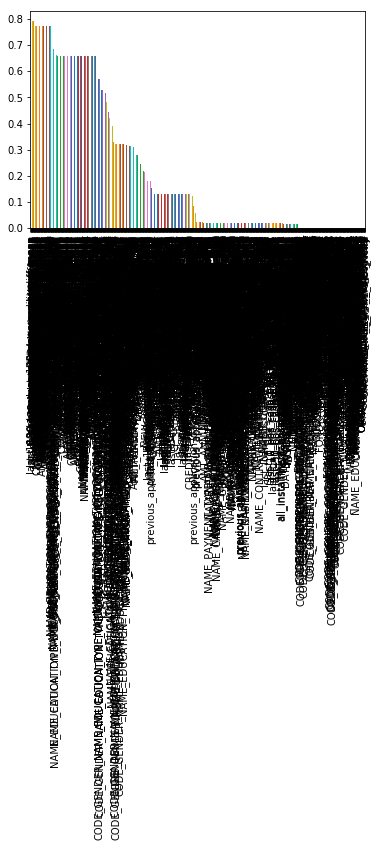

In [26]:
ColNullTest.plot(kind='bar')

In [27]:
#看行的情况
RowNullTrain = AllTrainData.isnull().sum(axis=1).sort_values()
RowNullTest = TestData.isnull().sum(axis=1).sort_values()

In [28]:
RowNullTrainFrame = RowNullTrain.to_frame().reset_index().rename(index=str,columns={'index':'id',0:'NULLnum'})

In [29]:
RowNullTrainFrame.columns

Index(['id', 'NULLnum'], dtype='object')

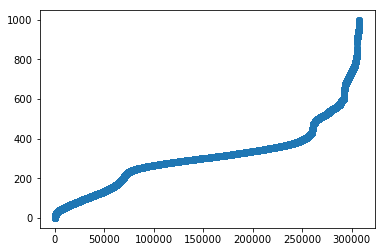

In [30]:
plt.scatter(RowNullTrainFrame.index,RowNullTrainFrame.NULLnum)

In [31]:
RowNullTestFrame = RowNullTest.to_frame().reset_index().rename(index=str,columns={'index':'id',0:'NULLnum'})

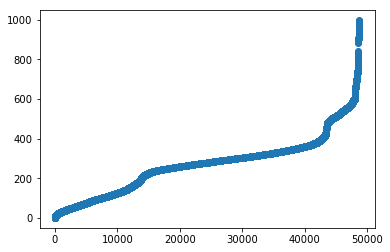

In [32]:
plt.scatter(RowNullTestFrame.index,RowNullTestFrame.NULLnum)

In [34]:
AllTrainDataSTD = AllTrainData.std()
TestDataSTD = TestData.std()

In [70]:
tmp1= set(AllTrainDataSTD[AllTrainDataSTD==0].index)
tmp1

{'1_period_trend_SK_DPD',
 '1_period_trend_SK_DPD_DEF',
 'DAYS_DIFF_min',
 'NAME_GOODS_CATEGORY_House Construction_sum',
 'SK_DPD_DEF_min_max_prevapp',
 'SK_DPD_DEF_min_mean_prevapp',
 'SK_DPD_DEF_min_min_prevapp',
 'SK_DPD_min_max_prevapp',
 'SK_DPD_min_mean_prevapp',
 'SK_DPD_min_min_prevapp',
 'last_1_pos_cash_paid_late_count',
 'last_1_pos_cash_paid_late_with_tolerance_count'}

In [71]:
tmp2 = set(TestDataSTD[TestDataSTD==0].index)
tmp2

{'1_period_trend_SK_DPD',
 '1_period_trend_SK_DPD_DEF',
 'DAYS_DIFF_min',
 'NAME_CONTRACT_STATUS_Approved_sum_max',
 'NAME_CONTRACT_STATUS_Approved_sum_mean',
 'NAME_GOODS_CATEGORY_Animals_sum',
 'NAME_INCOME_TYPE_Maternity leave',
 'SK_DPD_DEF_min_min_traintest',
 'all_installment_SK_DPD_DEF_min',
 'last_180_bureau_unusual_currency_mean',
 'last_180_bureau_unusual_currency_sum',
 'last_1_pos_cash_paid_late_count',
 'last_1_pos_cash_paid_late_with_tolerance_count',
 'last_360_CNT_CREDIT_PROLONG_min',
 'last_50_SK_DPD_DEF_min',
 'last_60_CNT_CREDIT_PROLONG_sum',
 'last_60_bureau_unusual_currency_sum'}

In [75]:
AllTrainData.shape

(294752, 1239)

In [74]:
AllTrainData.drop(tmp1&tmp2,axis=1,inplace=True)

In [85]:
features = [x for x in AllTrainData.columns if x != 'TARGET' and x != 'SK_ID_CURR']
len(features)

1238

In [34]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=False, cv_folds=5, 
             early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['TARGET'].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=
                          alg.get_params()['n_estimators'], nfold=cv_folds,
             early_stopping_rounds=early_stopping_rounds)
        print(cvresult.shape[0])
        for i in cvresult:
            print(i)
        alg.set_params(n_estimators=cvresult.shape[0])
    #建模
    alg.fit(dtrain[predictors], dtrain['TARGET'],eval_metric='auc')
    #对训练集预测
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    #对测试集预测
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
    #输出模型的一些结果
    print("\n关于现在这个模型")
    print ("训练准确率 : %.4g" % metrics.accuracy_score(
        dtrain['TARGET'].values, dtrain_predictions))
    print ("测试准确率 : %.4g" % metrics.accuracy_score(
        dtest['TARGET'].values, dtest_predictions))
    print ("训练AUC 得分 (训练集): %f" % metrics.roc_auc_score(dtrain['TARGET'],
                                                     dtrain_predprob))
    print ("测试AUC 得分 (验证集): %f" % metrics.roc_auc_score(dtest['TARGET'],
                                                     dtest_predprob))
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp[:20].plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return alg

## 随便试一下
这个随手一试的验证集在线上的roc达到了0.762


关于现在这个模型
训练准确率 : 0.784
测试准确率 : 0.7684
训练AUC 得分 (训练集): 0.844112
测试AUC 得分 (验证集): 0.778250


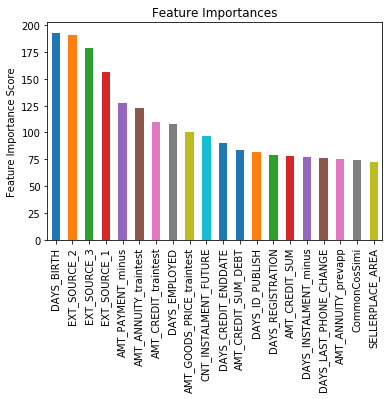

In [15]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=200,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.6,
        colsample_bytree=0.9,
        objective= 'binary:logistic',
        nthread= -1,
        gpu_id = 0,
        tree_method = 'gpu_hist',
        scale_pos_weight=10,
        early_stopping_rounds=20,
        seed=27)
xgb1 = modelfit(xgb1, TrainData, ValData, predictors)

## 结果提交

In [32]:
Testsubmission = loadData('test.csv')
TestID = Testsubmission.SK_ID_CURR.values
Testsub_predprob = xgb1.predict_proba(Testsubmission[predictors])[:,1]
gender_submission = pd.DataFrame({'SK_ID_CURR':TestID,'TARGET':Testsub_predprob})
gender_submission.to_csv('result_xgb.csv', index = False)

### 1.搜索learning_rate

In [23]:
#对learning_rate用grid search查找最好的参数
t0 = time.time()
param_test1 = {'learning_rate':np.linspace(0.001,0.2,10)}
clf = XGBClassifier(learning_rate =0.01, n_estimators=1000, max_depth=4 , 
                        min_child_weight=5, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                       nthread=-1, scale_pos_weight=1, seed=27, reg_lambda = 1.2, gamma=0, gpu_id = 0,tree_method = 'gpu_hist')
gsearch1 = GridSearchCV(estimator = clf, 
                        param_grid = param_test1, scoring='roc_auc',
                        n_jobs=-1,iid=False,verbose=10)#默认使用三折StratifiedKFold解决样本不均衡的问题
gsearch1.fit(df_[features],ValData['TARGET'])
print('搜索耗时%f s'%(time.time()-t0))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001 .............................................
[CV] learning_rate=0.001 .............................................
[CV] learning_rate=0.001 .............................................
[CV] learning_rate=0.023111111111111114 ..............................
[CV] learning_rate=0.023111111111111114 ..............................
[CV] learning_rate=0.023111111111111114 ..............................
[CV] learning_rate=0.045222222222222226 ..............................
[CV] learning_rate=0.045222222222222226 ..............................
[CV] learning_rate=0.045222222222222226 ..............................
[CV] learning_rate=0.06733333333333334 ...............................
[CV] learning_rate=0.06733333333333334 ...............................
[CV] learning_rate=0.06733333333333334 ...............................
[CV] learning_rate=0.08944444444444445 ...............................
[CV] learning_ra

Process ForkPoolWorker-31:
Process ForkPoolWorker-30:
Process ForkPoolWorker-28:
Process ForkPoolWorker-27:
Process ForkPoolWorker-36:
Process ForkPoolWorker-29:
Process ForkPoolWorker-34:
Process ForkPoolWorker-33:
Process ForkPoolWorker-25:
Process ForkPoolWorker-32:
Process ForkPoolWorker-26:
Process ForkPoolWorker-35:


KeyboardInterrupt: 

In [16]:
for i in gsearch1.grid_scores_:
    print(i) 
print(gsearch1.best_params_)
print(gsearch1.best_score_)

mean: 0.72621, std: 0.00148, params: {'learning_rate': 0.001}
mean: 0.75850, std: 0.00205, params: {'learning_rate': 0.023111111111111114}
mean: 0.76834, std: 0.00184, params: {'learning_rate': 0.045222222222222226}
mean: 0.77126, std: 0.00265, params: {'learning_rate': 0.06733333333333334}
mean: 0.77253, std: 0.00263, params: {'learning_rate': 0.08944444444444445}
mean: 0.77191, std: 0.00237, params: {'learning_rate': 0.11155555555555556}
mean: 0.77139, std: 0.00223, params: {'learning_rate': 0.13366666666666668}
mean: 0.76862, std: 0.00157, params: {'learning_rate': 0.1557777777777778}
mean: 0.76740, std: 0.00248, params: {'learning_rate': 0.1778888888888889}
mean: 0.76493, std: 0.00155, params: {'learning_rate': 0.2}
{'learning_rate': 0.08944444444444445}
0.7725270336719353


## 2. 搜索 n_estimators

In [15]:
#对learning_rate用grid search查找最好的参数
t0 = time.time()
param_test1 = {'n_estimators':np.arange(100,601,100)}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.08944444444444445, n_estimators=140,
                                                  max_depth=5,min_child_weight=1,
                                                  gamma=0, subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  gpu_id = 0,
                                                  tree_method = 'gpu_hist',
                                                  nthread= -1, scale_pos_weight=12), 
                        param_grid = param_test1, scoring='roc_auc'
                        ,n_jobs=-1,iid=False, cv=StratifiedKFold(),verbose=10)#默认使用三折StratifiedKFold解决样本不均衡的问题
gsearch1.fit(TrainData[predictors],TrainData['TARGET'])
print('搜索耗时%f s'%(time.time()-t0))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_estimators=100 ................................................
[CV] n_estimators=100 ................................................
[CV] n_estimators=100 ................................................
[CV] n_estimators=200 ................................................
[CV] n_estimators=200 ................................................
[CV] n_estimators=200 ................................................
[CV] n_estimators=300 ................................................
[CV] n_estimators=300 ................................................
[CV] ....... n_estimators=100, score=0.7658831364704137, total= 4.2min
[CV] n_estimators=300 ................................................
[CV] ....... n_estimators=100, score=0.7720692711112049, total= 4.3min
[CV] n_estimators=400 ................................................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.4min


[CV] ....... n_estimators=100, score=0.7717769089299386, total= 4.4min
[CV] n_estimators=400 ................................................
[CV] ....... n_estimators=200, score=0.7752096392575916, total= 8.2min
[CV] n_estimators=400 ................................................
[CV] ....... n_estimators=200, score=0.7691542337261386, total= 8.2min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:  8.3min remaining: 21.7min


[CV] ....... n_estimators=200, score=0.7746042978607441, total= 8.3min
[CV] n_estimators=500 ................................................
[CV] ....... n_estimators=300, score=0.7695947289567895, total=12.0min
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed: 12.2min remaining: 19.1min


[CV] ........ n_estimators=300, score=0.774187786158629, total=12.1min
[CV] n_estimators=600 ................................................
[CV] ....... n_estimators=300, score=0.7731540805211297, total=12.1min
[CV] n_estimators=600 ................................................


[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed: 16.4min remaining: 16.4min


[CV] ....... n_estimators=400, score=0.7684113155117458, total=15.8min
[CV] n_estimators=600 ................................................
[CV] ....... n_estimators=400, score=0.7722216995700042, total=15.8min


[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed: 20.3min remaining: 12.9min


[CV] ....... n_estimators=400, score=0.7708943787461713, total=15.3min
[CV] ....... n_estimators=500, score=0.7662995802461414, total=18.1min


[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed: 26.5min remaining: 10.2min


[CV] ........ n_estimators=500, score=0.770586639132155, total=18.0min
[CV] ....... n_estimators=500, score=0.7687507931338964, total=16.2min


[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed: 28.4min remaining:  5.7min


[CV] ....... n_estimators=600, score=0.7646049661515264, total=17.6min
[CV] ........ n_estimators=600, score=0.769008098639991, total=14.5min
[CV] ....... n_estimators=600, score=0.7659637776481978, total=11.0min


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 31.3min finished


NameError: name 't0' is not defined

In [16]:
for i in gsearch1.grid_scores_:
    print(i) 
print(gsearch1.best_params_)
print(gsearch1.best_score_)

mean: 0.76991, std: 0.00285, params: {'n_estimators': 100}
mean: 0.77299, std: 0.00272, params: {'n_estimators': 200}
mean: 0.77231, std: 0.00197, params: {'n_estimators': 300}
mean: 0.77051, std: 0.00158, params: {'n_estimators': 400}
mean: 0.76855, std: 0.00176, params: {'n_estimators': 500}
mean: 0.76653, std: 0.00184, params: {'n_estimators': 600}
{'n_estimators': 200}
0.7729893902814915


### 3. max_depth和min_child_weight

In [16]:
t0 = time.time()
param_test1 = {'max_depth':list(range(3,10,2)),
    'min_child_weight':list(range(1,6,2))}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.08944444444444445, n_estimators=200,
                                                  max_depth=5,min_child_weight=1,
                                                  gamma=0, subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  gpu_id = 0,
                                                  tree_method = 'gpu_hist',
                                                  nthread= -1, scale_pos_weight=12), 
                        param_grid = param_test1, scoring='roc_auc'
                        ,n_jobs=-1,iid=False, cv=StratifiedKFold(),verbose=10)#默认使用三折StratifiedKFold解决样本不均衡的问题
gsearch1.fit(TrainData[predictors],TrainData['TARGET'])
print('搜索耗时%f s'%(time.time()-t0))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] min_child_weight=1, max_depth=3 .................................
[CV] min_child_weight=1, max_depth=3 .................................
[CV] min_child_weight=1, max_depth=3 .................................
[CV] min_child_weight=3, max_depth=3 .................................
[CV] min_child_weight=3, max_depth=3 .................................
[CV] min_child_weight=3, max_depth=3 .................................
[CV] min_child_weight=5, max_depth=3 .................................
[CV] min_child_weight=5, max_depth=3 .................................
[CV]  min_child_weight=1, max_depth=3, score=0.772402599009216, total= 6.4min
[CV] min_child_weight=5, max_depth=3 .................................
[CV]  min_child_weight=1, max_depth=3, score=0.7718250135994211, total= 6.6min
[CV] min_child_weight=1, max_depth=5 .................................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  6.7min


[CV]  min_child_weight=1, max_depth=3, score=0.7722518527838016, total= 6.6min
[CV] min_child_weight=1, max_depth=5 .................................
[CV]  min_child_weight=3, max_depth=3, score=0.7727400490819161, total= 6.7min
[CV] min_child_weight=1, max_depth=5 .................................
[CV]  min_child_weight=3, max_depth=3, score=0.7723932906355246, total= 6.7min
[CV] min_child_weight=3, max_depth=5 .................................
[CV]  min_child_weight=5, max_depth=3, score=0.7724101575895475, total= 6.7min
[CV] min_child_weight=3, max_depth=5 .................................
[CV]  min_child_weight=3, max_depth=3, score=0.7717756977789028, total= 6.7min
[CV] min_child_weight=3, max_depth=5 .................................
[CV]  min_child_weight=5, max_depth=3, score=0.772115326241084, total= 6.7min
[CV] min_child_weight=5, max_depth=5 .................................
[CV]  min_child_weight=5, max_depth=3, score=0.7723432253662552, total= 5.9min
[CV] min_child_weight=

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 12.5min


[CV]  min_child_weight=1, max_depth=5, score=0.7736846466967335, total= 8.6min
[CV] min_child_weight=5, max_depth=5 .................................
[CV]  min_child_weight=1, max_depth=5, score=0.770786898901294, total= 8.6min
[CV] min_child_weight=1, max_depth=7 .................................
[CV]  min_child_weight=1, max_depth=5, score=0.7748534679894716, total= 8.6min
[CV] min_child_weight=1, max_depth=7 .................................
[CV]  min_child_weight=3, max_depth=5, score=0.774477103459106, total= 8.5min
[CV] min_child_weight=1, max_depth=7 .................................
[CV]  min_child_weight=3, max_depth=5, score=0.7733565768483791, total= 8.6min
[CV] min_child_weight=3, max_depth=7 .................................
[CV]  min_child_weight=3, max_depth=5, score=0.7724818315311615, total= 8.6min
[CV] min_child_weight=3, max_depth=7 .................................
[CV]  min_child_weight=5, max_depth=5, score=0.7739213806480864, total= 8.6min
[CV] min_child_weight=3

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 15.5min


[CV]  min_child_weight=5, max_depth=5, score=0.7720056438278007, total= 7.5min
[CV] min_child_weight=5, max_depth=7 .................................
[CV]  min_child_weight=5, max_depth=5, score=0.7737987869425133, total= 6.7min
[CV] min_child_weight=5, max_depth=7 .................................
[CV]  min_child_weight=3, max_depth=7, score=0.7643567227891559, total=10.6min
[CV] min_child_weight=5, max_depth=7 .................................
[CV]  min_child_weight=1, max_depth=7, score=0.7638819437355417, total=10.7min
[CV] min_child_weight=1, max_depth=9 .................................
[CV]  min_child_weight=1, max_depth=7, score=0.7637463654482247, total=10.8min
[CV] min_child_weight=1, max_depth=9 .................................
[CV]  min_child_weight=3, max_depth=7, score=0.7627335985979067, total=10.7min
[CV] min_child_weight=1, max_depth=9 .................................
[CV]  min_child_weight=3, max_depth=7, score=0.7635810583671689, total=10.8min
[CV] min_child_weight

[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed: 29.5min remaining: 13.0min


[CV]  min_child_weight=5, max_depth=7, score=0.7623441298318753, total= 8.7min
[CV] min_child_weight=5, max_depth=9 .................................
[CV]  min_child_weight=5, max_depth=7, score=0.765464770342116, total= 7.6min
[CV] min_child_weight=5, max_depth=9 .................................
[CV]  min_child_weight=1, max_depth=9, score=0.7485449014339651, total=13.6min
[CV] min_child_weight=5, max_depth=9 .................................
[CV]  min_child_weight=3, max_depth=9, score=0.7476582053494809, total=13.5min


[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 39.9min remaining:  9.6min


[CV]  min_child_weight=3, max_depth=9, score=0.7484115492579468, total=13.6min
[CV]  min_child_weight=1, max_depth=9, score=0.7481158643114207, total=13.9min
[CV]  min_child_weight=1, max_depth=9, score=0.7455355612569118, total=14.0min
[CV]  min_child_weight=3, max_depth=9, score=0.7517984127988624, total=11.8min


[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 41.3min remaining:  3.8min


[CV]  min_child_weight=5, max_depth=9, score=0.7518180791888766, total=10.9min
[CV]  min_child_weight=5, max_depth=9, score=0.7505696791461578, total= 8.7min
[CV]  min_child_weight=5, max_depth=9, score=0.7503873773723964, total= 3.3min


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 43.2min finished


搜索耗时2675.820019 s


In [17]:
for i in gsearch1.grid_scores_:
    print(i) 
print(gsearch1.best_params_)
print(gsearch1.best_score_)

mean: 0.77216, std: 0.00024, params: {'min_child_weight': 1, 'max_depth': 3}
mean: 0.77230, std: 0.00040, params: {'min_child_weight': 3, 'max_depth': 3}
mean: 0.77229, std: 0.00013, params: {'min_child_weight': 5, 'max_depth': 3}
mean: 0.77311, std: 0.00171, params: {'min_child_weight': 1, 'max_depth': 5}
mean: 0.77344, std: 0.00082, params: {'min_child_weight': 3, 'max_depth': 5}
mean: 0.77324, std: 0.00088, params: {'min_child_weight': 5, 'max_depth': 5}
mean: 0.76347, std: 0.00049, params: {'min_child_weight': 1, 'max_depth': 7}
mean: 0.76356, std: 0.00066, params: {'min_child_weight': 3, 'max_depth': 7}
mean: 0.76406, std: 0.00129, params: {'min_child_weight': 5, 'max_depth': 7}
mean: 0.74740, std: 0.00133, params: {'min_child_weight': 1, 'max_depth': 9}
mean: 0.74929, std: 0.00180, params: {'min_child_weight': 3, 'max_depth': 9}
mean: 0.75093, std: 0.00064, params: {'min_child_weight': 5, 'max_depth': 9}
{'min_child_weight': 3, 'max_depth': 5}
0.7734385039462156


### 4. gamma

In [16]:
t0 = time.time()
param_test1 = {'gamma':[i/10.0 for i in range(0,5)]}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.08944444444444445, n_estimators=200,
                                                  max_depth=5,min_child_weight=3,
                                                  gamma=0, subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  gpu_id = 0,
                                                  tree_method = 'gpu_hist',
                                                  nthread= -1, scale_pos_weight=12), 
                        param_grid = param_test1, scoring='roc_auc'
                        ,n_jobs=-1,iid=False, cv=StratifiedKFold(),verbose=10)#默认使用三折StratifiedKFold解决样本不均衡的问题
gsearch1.fit(TrainData[predictors],TrainData['TARGET'])
print('搜索耗时%f s'%(time.time()-t0))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] gamma=0.1 .......................................................
[CV] gamma=0.1 .......................................................
[CV] gamma=0.1 .......................................................
[CV] gamma=0.2 .......................................................
[CV] gamma=0.2 .......................................................
[CV] .............. gamma=0.0, score=0.7753966991423382, total= 8.0min
[CV] gamma=0.2 .......................................................
[CV] .............. gamma=0.0, score=0.7753448800967799, total= 8.1min
[CV] gamma=0.3 .......................................................


[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  8.2min remaining: 53.1min


[CV] .............. gamma=0.0, score=0.7703502449465338, total= 8.2min
[CV] gamma=0.3 .......................................................
[CV] .............. gamma=0.1, score=0.7753966991423382, total= 8.3min
[CV] gamma=0.3 .......................................................


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  8.4min remaining: 23.0min


[CV] .............. gamma=0.2, score=0.7753966991423382, total= 8.3min
[CV] gamma=0.4 .......................................................
[CV] .............. gamma=0.1, score=0.7753448800967799, total= 8.3min


[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  8.4min remaining: 12.6min


[CV] gamma=0.4 .......................................................
[CV] .............. gamma=0.2, score=0.7753448800967799, total= 8.3min
[CV] gamma=0.4 .......................................................
[CV] .............. gamma=0.1, score=0.7703502449465338, total= 8.3min


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  8.5min remaining:  7.4min


[CV] .............. gamma=0.2, score=0.7703502449465338, total= 7.4min
[CV] .............. gamma=0.3, score=0.7753966991423382, total= 7.4min


[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 15.6min remaining:  7.8min


[CV] .............. gamma=0.3, score=0.7753448800967799, total= 7.4min
[CV] .............. gamma=0.3, score=0.7703502449465338, total= 7.4min


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 15.8min remaining:  3.9min


[CV] .............. gamma=0.4, score=0.7753966991423382, total= 7.3min
[CV] .............. gamma=0.4, score=0.7703502449465338, total= 7.3min
[CV] .............. gamma=0.4, score=0.7753448800967799, total= 7.3min


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 15.8min finished


搜索耗时1032.196386 s


In [17]:
for i in gsearch1.grid_scores_:
    print(i) 
print(gsearch1.best_params_)
print(gsearch1.best_score_)

mean: 0.77370, std: 0.00237, params: {'gamma': 0.0}
mean: 0.77370, std: 0.00237, params: {'gamma': 0.1}
mean: 0.77370, std: 0.00237, params: {'gamma': 0.2}
mean: 0.77370, std: 0.00237, params: {'gamma': 0.3}
mean: 0.77370, std: 0.00237, params: {'gamma': 0.4}
{'gamma': 0.0}
0.7736972747285508


In [56]:
#也没啥用 心累

### 5.subsample and colsample_bytree

In [15]:
t0 = time.time()
param_test1 = {'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.08944444444444445, n_estimators=200,
                                                  max_depth=5,min_child_weight=3,
                                                  gamma=0, subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  gpu_id = 0,
                                                  tree_method = 'gpu_hist',
                                                  nthread= -1, scale_pos_weight=12), 
                        param_grid = param_test1, scoring='roc_auc'
                        ,n_jobs=-1,iid=False, cv=StratifiedKFold(),verbose=10)#默认使用三折StratifiedKFold解决样本不均衡的问题
gsearch1.fit(TrainData[predictors],TrainData['TARGET'])
print('搜索耗时%f s'%(time.time()-t0))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.7700571584552429, total= 6.3min
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.7699194570958718, total= 6.4min
[CV] colsample_bytree=0.6, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  6.5min


[CV]  colsample_bytree=0.6, subsample=0.6, score=0.7730652924251193, total= 6.6min
[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.7740366149976063, total= 7.4min
[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.7707500084963684, total= 7.5min
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.774689104592011, total= 7.7min
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=0.7721282578288697, total= 8.3min
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=0.7746354219471022, total= 8.4min
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.7725322273541873, total= 6

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 14.5min


[CV]  colsample_bytree=0.7, subsample=0.6, score=0.7691707617174233, total= 6.9min
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=0.7751344288709778, total= 8.7min
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=0.7737891891859092, total= 8.9min
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.7754946730595352, total= 7.0min
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=0.7722818124227036, total= 8.9min
[CV] colsample_bytree=0.7, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=0.7752053125970882, total= 8.9min
[CV] colsample_bytree=0.7, subsample=0.9 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.7720914588115486, total= 

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 16.4min


[CV]  colsample_bytree=0.7, subsample=0.7, score=0.7696656346299586, total= 7.8min
[CV] colsample_bytree=0.8, subsample=0.6 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.7740433374325171, total= 8.0min
[CV] colsample_bytree=0.8, subsample=0.6 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=0.7728143559420532, total= 8.7min
[CV] colsample_bytree=0.8, subsample=0.6 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=0.770449310823147, total= 8.5min
[CV] colsample_bytree=0.8, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=0.7745144097884693, total= 8.7min
[CV] colsample_bytree=0.8, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.9, score=0.7740215449146065, total= 9.0min
[CV] colsample_bytree=0.8, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.9, score=0.7714013252388473, total= 8

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 29.1min


[CV]  colsample_bytree=0.8, subsample=0.6, score=0.7701305845258698, total= 6.7min
[CV] colsample_bytree=0.8, subsample=0.9 .............................
[CV]  colsample_bytree=0.8, subsample=0.6, score=0.7730138603601346, total= 6.8min
[CV] colsample_bytree=0.8, subsample=0.9 .............................
[CV]  colsample_bytree=0.8, subsample=0.7, score=0.7710904648836095, total= 7.4min
[CV] colsample_bytree=0.8, subsample=0.9 .............................
[CV]  colsample_bytree=0.8, subsample=0.7, score=0.7732796388699674, total= 7.6min
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV]  colsample_bytree=0.8, subsample=0.7, score=0.7743021745345758, total= 7.8min
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV]  colsample_bytree=0.8, subsample=0.8, score=0.7747142234163396, total= 8.4min
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV]  colsample_bytree=0.8, subsample=0.8, score=0.7703553027446493, total= 

[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed: 40.6min remaining: 10.7min


[CV]  colsample_bytree=0.8, subsample=0.9, score=0.7753050376746972, total= 8.9min
[CV] colsample_bytree=0.9, subsample=0.9 .............................
[CV]  colsample_bytree=0.9, subsample=0.7, score=0.7722825156604107, total= 7.8min
[CV] colsample_bytree=0.9, subsample=0.9 .............................
[CV]  colsample_bytree=0.9, subsample=0.7, score=0.7710452978439607, total= 7.7min
[CV]  colsample_bytree=0.9, subsample=0.7, score=0.7752761440056594, total= 7.9min
[CV]  colsample_bytree=0.9, subsample=0.8, score=0.7741528641323059, total= 8.4min


[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed: 47.1min remaining:  5.5min


[CV]  colsample_bytree=0.9, subsample=0.8, score=0.7712713109218389, total= 8.1min
[CV]  colsample_bytree=0.9, subsample=0.8, score=0.7757863197984511, total= 8.0min
[CV]  colsample_bytree=0.9, subsample=0.9, score=0.7706073647253636, total= 7.3min
[CV]  colsample_bytree=0.9, subsample=0.9, score=0.7734253403137024, total= 7.4min
[CV]  colsample_bytree=0.9, subsample=0.9, score=0.776042176108706, total= 6.6min


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 48.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 48.2min finished


搜索耗时2976.900270 s


In [16]:
for i in gsearch1.grid_scores_:
    print(i) 
print(gsearch1.best_params_)
print(gsearch1.best_score_)

mean: 0.77101, std: 0.00145, params: {'colsample_bytree': 0.6, 'subsample': 0.6}
mean: 0.77316, std: 0.00172, params: {'colsample_bytree': 0.6, 'subsample': 0.7}
mean: 0.77397, std: 0.00132, params: {'colsample_bytree': 0.6, 'subsample': 0.8}
mean: 0.77376, std: 0.00119, params: {'colsample_bytree': 0.6, 'subsample': 0.9}
mean: 0.77240, std: 0.00258, params: {'colsample_bytree': 0.7, 'subsample': 0.6}
mean: 0.77193, std: 0.00179, params: {'colsample_bytree': 0.7, 'subsample': 0.7}
mean: 0.77259, std: 0.00167, params: {'colsample_bytree': 0.7, 'subsample': 0.8}
mean: 0.77332, std: 0.00137, params: {'colsample_bytree': 0.7, 'subsample': 0.9}
mean: 0.77080, std: 0.00161, params: {'colsample_bytree': 0.8, 'subsample': 0.6}
mean: 0.77289, std: 0.00134, params: {'colsample_bytree': 0.8, 'subsample': 0.7}
mean: 0.77347, std: 0.00221, params: {'colsample_bytree': 0.8, 'subsample': 0.8}
mean: 0.77356, std: 0.00142, params: {'colsample_bytree': 0.8, 'subsample': 0.9}
mean: 0.77113, std: 0.00117,

### 6. eta

In [18]:
t0 = time.time()
param_test1 = {'eta':[i/10 for i in range(1,11)] }
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.08944444444444445, n_estimators=200,
                                                  max_depth=5,min_child_weight=3,
                                                  eta = 0.3, gamma=0, subsample=0.8,
                                                  colsample_bytree=0.6,
                                                  objective= 'binary:logistic',
                                                  gpu_id = 0,
                                                  tree_method = 'gpu_hist',
                                                  nthread= -1, scale_pos_weight=12), 
                        param_grid = param_test1, scoring='roc_auc'
                        ,n_jobs=-1,iid=False, cv=StratifiedKFold(),verbose=10)#默认使用三折StratifiedKFold解决样本不均衡的问题
gsearch1.fit(TrainData[predictors],TrainData['TARGET'])
print('搜索耗时%f s'%(time.time()-t0))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] eta=0.1 .........................................................
[CV] eta=0.1 .........................................................
[CV] eta=0.1 .........................................................
[CV] eta=0.2 .........................................................
[CV] eta=0.2 .........................................................
[CV] eta=0.2 .........................................................
[CV] eta=0.3 .........................................................
[CV] eta=0.3 .........................................................
[CV] ................ eta=0.1, score=0.7783389510759824, total= 8.0min
[CV] eta=0.3 .........................................................
[CV] ................ eta=0.2, score=0.7783389510759824, total= 8.2min
[CV] eta=0.4 .........................................................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  8.3min


[CV] ................ eta=0.1, score=0.7706502271774047, total= 8.2min
[CV] eta=0.4 .........................................................
[CV] ................ eta=0.1, score=0.7707047328978254, total= 8.3min
[CV] eta=0.4 .........................................................
[CV] ................ eta=0.3, score=0.7783389510759824, total= 8.3min
[CV] eta=0.5 .........................................................
[CV] ................ eta=0.3, score=0.7707047328978254, total= 8.3min
[CV] eta=0.5 .........................................................
[CV] ................ eta=0.2, score=0.7707047328978254, total= 8.4min
[CV] eta=0.5 .........................................................
[CV] ................ eta=0.2, score=0.7706502271774047, total= 8.4min
[CV] eta=0.6 .........................................................
[CV] ................ eta=0.4, score=0.7783389510759824, total= 8.5min
[CV] eta=0.6 .........................................................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 16.8min


[CV] ................ eta=0.3, score=0.7706502271774047, total= 8.7min
[CV] eta=0.6 .........................................................
[CV] ................ eta=0.4, score=0.7707047328978254, total= 8.5min
[CV] eta=0.7 .........................................................
[CV] ................ eta=0.5, score=0.7783389510759824, total= 8.5min
[CV] eta=0.7 .........................................................
[CV] ................ eta=0.6, score=0.7783389510759824, total= 8.5min
[CV] eta=0.7 .........................................................
[CV] ................ eta=0.4, score=0.7706502271774047, total= 8.7min
[CV] eta=0.8 .........................................................
[CV] ................ eta=0.5, score=0.7707047328978254, total= 8.6min
[CV] eta=0.8 .........................................................
[CV] ................ eta=0.5, score=0.7706502271774047, total= 8.6min
[CV] eta=0.8 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 25.5min remaining: 14.8min


[CV] eta=0.9 .........................................................
[CV] ................ eta=0.7, score=0.7707047328978254, total= 8.6min
[CV] eta=1.0 .........................................................
[CV] ................ eta=0.8, score=0.7783389510759824, total= 8.5min
[CV] eta=1.0 .........................................................
[CV] ................ eta=0.8, score=0.7707047328978254, total= 8.5min
[CV] eta=1.0 .........................................................
[CV] ................ eta=0.7, score=0.7706502271774047, total= 8.7min


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 25.8min remaining:  7.9min


[CV] ................ eta=0.8, score=0.7706502271774047, total= 8.7min
[CV] ................ eta=0.9, score=0.7783389510759824, total= 6.5min
[CV] ................ eta=0.9, score=0.7707047328978254, total= 6.5min
[CV] ................ eta=1.0, score=0.7783389510759824, total= 6.5min


[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 32.1min remaining:  3.6min


[CV] ................ eta=1.0, score=0.7707047328978254, total= 6.5min
[CV] ................ eta=0.9, score=0.7706502271774047, total= 6.6min
[CV] ................ eta=1.0, score=0.7706502271774047, total= 6.4min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 32.2min finished


搜索耗时2015.866491 s


In [19]:
for i in gsearch1.grid_scores_:
    print(i) 
print(gsearch1.best_params_)
print(gsearch1.best_score_)

mean: 0.77323, std: 0.00361, params: {'eta': 0.1}
mean: 0.77323, std: 0.00361, params: {'eta': 0.2}
mean: 0.77323, std: 0.00361, params: {'eta': 0.3}
mean: 0.77323, std: 0.00361, params: {'eta': 0.4}
mean: 0.77323, std: 0.00361, params: {'eta': 0.5}
mean: 0.77323, std: 0.00361, params: {'eta': 0.6}
mean: 0.77323, std: 0.00361, params: {'eta': 0.7}
mean: 0.77323, std: 0.00361, params: {'eta': 0.8}
mean: 0.77323, std: 0.00361, params: {'eta': 0.9}
mean: 0.77323, std: 0.00361, params: {'eta': 1.0}
{'eta': 0.1}
0.7732313037170707


In [17]:
[i/10 for i in range(1,11)]

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

### 还不如不搜


关于现在这个模型
训练准确率 : 0.9229
测试准确率 : 0.9194
训练AUC 得分 (训练集): 0.843205
测试AUC 得分 (验证集): 0.782402
耗时203.354518 s


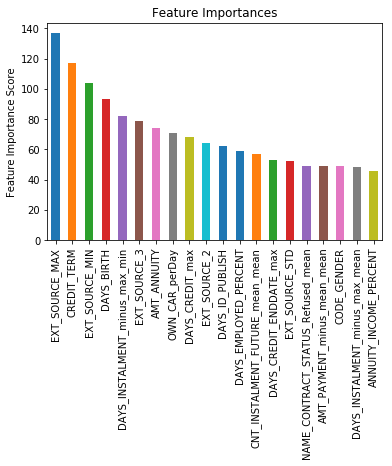

In [13]:
xgbmodel = XGBClassifier(booster='dart',learning_rate = 0.08944444444444445, n_estimators=200,
                                                  max_depth=5,min_child_weight=3,
                                                  eta = 0.3, gamma=0, subsample=0.8,
                                                  colsample_bytree=0.6,
                                                  objective= 'binary:logistic',
                                                  gpu_id = 0,
                                                  tree_method = 'gpu_hist',
                                                  nthread= -1, scale_pos_weight=1)
t0 = time.time()
xgbmodel = modelfit(xgbmodel, TrainData, ValData, predictors, useTrainCV = False)
print('耗时%f s'%(time.time()-t0))

In [16]:
##将所有的数据放进去训练
t0 = time.time()
AllTrainData = TrainData.append(ValData)
AllTrainData.reset_index(drop=True, inplace =True)
xgbmodel.fit(AllTrainData[predictors], AllTrainData['TARGET'],eval_metric='auc')
#对训练集预测
xgbmodel.save_model(os.path.join(ModelSaveDir,'xgb_0780.model'))
print('耗时%f s'%(time.time()-t0))

耗时251.844797 s


In [17]:
Testsubmission = loadData('test.csv')
TestID = Testsubmission.SK_ID_CURR.values
Testsub_predprob = xgbmodel.predict_proba(Testsubmission[predictors])[:,1]
gender_submission = pd.DataFrame({'SK_ID_CURR':TestID,'TARGET':Testsub_predprob})
gender_submission.to_csv(os.path.join(ResultSaveDir,'result_xgb_new.csv'), index = False)